# Hidden Markov Model: An implementation for shorting the volatility

In this notebook, we will implement an Hidden Markov Model in order to identify in which state of volatility we are right now to sell the volatility on the market. For further information on this topic please refer to the EMSE paper which describes the strategy.
An HMM is fully defined by: 

$$
\lambda = (\pi, A, B)
$$

First we will need initial distribution:

$$
\pi_i = P(q_1 = i)
$$
This is the prior belief about the regime at start.

The transition matrix of the Markov process is also relevant: 

$$
A =
\begin{pmatrix}
a_{11} & \cdots & a_{1N} \\
\vdots & \ddots & \vdots \\
a_{N1} & \cdots & a_{NN}
\end{pmatrix}
$$


Where $a_{ii}$ is the regime persistence of the state i and the expected duration of regime i is: $\mathbb{E}[T_i] = \frac{1}{1 - a_{ii}}$

Finally, we need the emission distribution B, if gaussian (which can be requestionned) $O_t \mid q_t = i \sim \mathcal{N}(\mu_i, \Sigma_i)$. We interpret this as each regime has: mean return, volatility, covariance structure. This is how the model learns regime.


We have here a lot of paramters we will try to optimize:

* duration between two observation
* how to cal

We also need to have a good data quality:

* Missing values
* Outliers

Hidden Markov Model:

* Gaussian emission densities with full covariance
* Baum-Welch (EM) algorithm for parameter estimation
* Viterbi decoding for most likely state sequence
* Model selection via AIC/BIC criteria

Let's optimize this hyper parameters:

* number of different states
* Normal law only?
* 

  

source:

- https://github.com/I-am-Uchenna/regime-allocation-strategy
- https://dms.umontreal.ca/~augusty/FHMV_paper.pdf

In [98]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import threading
import asyncio
import scipy
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

from ib_insync import *
from ib_insync import IB, Stock, util
from ib_insync import Future
from ib_insync import Stock
from ib_insync import Option
from ib_insync import Bond
from ib_insync import Forex
from ib_insync import Index
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D 
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown
import plotly.graph_objects as go
import plotly.io as pio
from scipy.integrate import quad
from hmmlearn import hmm
import warnings
warnings.filterwarnings('ignore')

pio.renderers.default = "notebook"
%matplotlib widget
%matplotlib ipympl

# Data

In [ ]:
ib = IB()
util.startLoop()
await ib.connectAsync('127.0.0.1', 7496, clientId=2) # Don't forget to change the client ID

Let's implement our strategie for the Euro stoxx 50 and we will adapt the same methodology for EU/US small and mid caps. First we will trade option on Euro stoxx 50, as a first implementation, we will not consider correlation between assets.

In [100]:
VIX = yf.Ticker("^VIX")
VVIX = yf.Ticker("^VVIX")

VIX_historical = VIX.history(start="2007-01-03", end="2026-02-03", interval="1D")


VVIX_historical = VVIX.history(start="2007-01-03", end="2026-02-03", interval="1D")



VIX_log_returns = pd.DataFrame(np.log(VIX_historical["Close"] / VIX_historical["Close"].shift(1)))
VIX_log_returns = VIX_log_returns.dropna()


In [101]:
VIX_historical

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-01-03 00:00:00-05:00,12.160000,12.750000,11.530000,12.040000,0,0.0,0.0
2007-01-04 00:00:00-05:00,12.400000,12.420000,11.280000,11.510000,0,0.0,0.0
2007-01-05 00:00:00-05:00,11.840000,12.250000,11.680000,12.140000,0,0.0,0.0
2007-01-08 00:00:00-05:00,12.480000,12.830000,11.780000,12.000000,0,0.0,0.0
2007-01-09 00:00:00-05:00,11.860000,12.470000,11.690000,11.910000,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-27 00:00:00-05:00,16.020000,16.370001,15.740000,16.350000,0,0.0,0.0
2026-01-28 00:00:00-05:00,16.090000,17.180000,16.049999,16.350000,0,0.0,0.0
2026-01-29 00:00:00-05:00,16.040001,19.740000,16.020000,16.879999,0,0.0,0.0


In [102]:
VVIX_historical

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-01-03 00:00:00-05:00,87.629997,87.629997,87.629997,87.629997,0,0.0,0.0
2007-01-04 00:00:00-05:00,88.190002,88.190002,88.190002,88.190002,0,0.0,0.0
2007-01-05 00:00:00-05:00,90.169998,90.169998,90.169998,90.169998,0,0.0,0.0
2007-01-08 00:00:00-05:00,92.040001,92.040001,92.040001,92.040001,0,0.0,0.0
2007-01-09 00:00:00-05:00,92.760002,92.760002,92.760002,92.760002,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-27 00:00:00-05:00,99.910004,101.260002,97.980003,101.260002,0,0.0,0.0
2026-01-28 00:00:00-05:00,101.489998,107.839996,99.000000,100.459999,0,0.0,0.0
2026-01-29 00:00:00-05:00,102.919998,111.919998,101.680000,101.760002,0,0.0,0.0


In [103]:
# We can see that there are missing values of the VVIx, we will as a first implementation, replace them by the mean of the values of the next and the previous day

missing_in_vvix = VIX_historical.index.difference(VVIX_historical.index)
print("Missing dates in VVIX:", missing_in_vvix)

VVIX_full = VVIX_historical.reindex(VIX_historical.index)

VVIX_full["Close"] = VVIX_full["Close"].interpolate(method="linear")


Missing dates in VVIX: DatetimeIndex(['2010-11-11 00:00:00-05:00', '2019-07-05 00:00:00-04:00',
               '2020-06-11 00:00:00-04:00', '2021-01-22 00:00:00-05:00',
               '2021-02-17 00:00:00-05:00', '2021-05-05 00:00:00-04:00',
               '2021-05-11 00:00:00-04:00', '2021-05-20 00:00:00-04:00',
               '2021-05-25 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', freq=None)


In [104]:
missing_in_vvix = VIX_historical.index.difference(VVIX_full.index)
print("Missing dates in VVIX:", missing_in_vvix)

Missing dates in VVIX: DatetimeIndex([], dtype='datetime64[ns, America/New_York]', name='Date', freq=None)


In [105]:
VIX = VIX_historical


VVIX = VVIX_full



<Axes: xlabel='Date'>

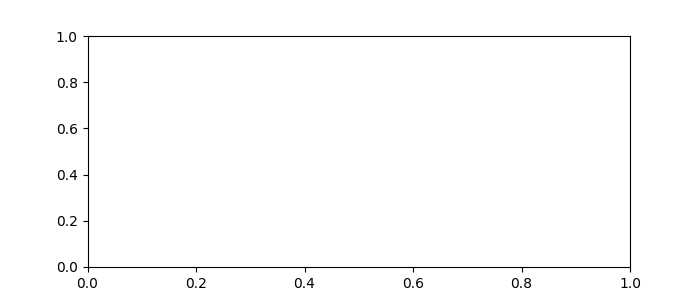

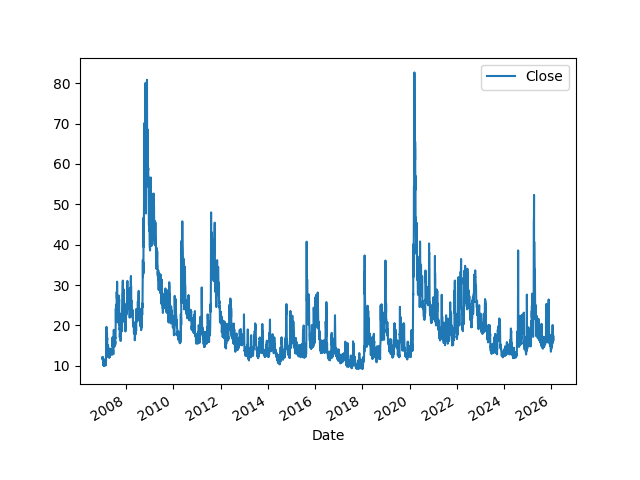

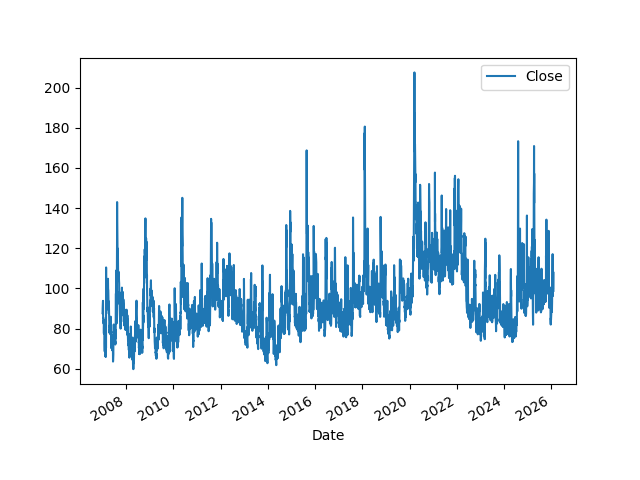

In [106]:
fig, ax = plt.subplots(figsize=(7,3))
VIX.plot( y = "Close")
VVIX.plot( y = "Close")






In [107]:
VIX, VVIX

(                                Open       High        Low      Close  Volume  \
 Date                                                                            
 2007-01-03 00:00:00-05:00  12.160000  12.750000  11.530000  12.040000       0   
 2007-01-04 00:00:00-05:00  12.400000  12.420000  11.280000  11.510000       0   
 2007-01-05 00:00:00-05:00  11.840000  12.250000  11.680000  12.140000       0   
 2007-01-08 00:00:00-05:00  12.480000  12.830000  11.780000  12.000000       0   
 2007-01-09 00:00:00-05:00  11.860000  12.470000  11.690000  11.910000       0   
 ...                              ...        ...        ...        ...     ...   
 2026-01-27 00:00:00-05:00  16.020000  16.370001  15.740000  16.350000       0   
 2026-01-28 00:00:00-05:00  16.090000  17.180000  16.049999  16.350000       0   
 2026-01-29 00:00:00-05:00  16.040001  19.740000  16.020000  16.879999       0   
 2026-01-30 00:00:00-05:00  18.719999  19.270000  16.670000  17.440001       0   
 2026-02-02 00:0

# HMM:

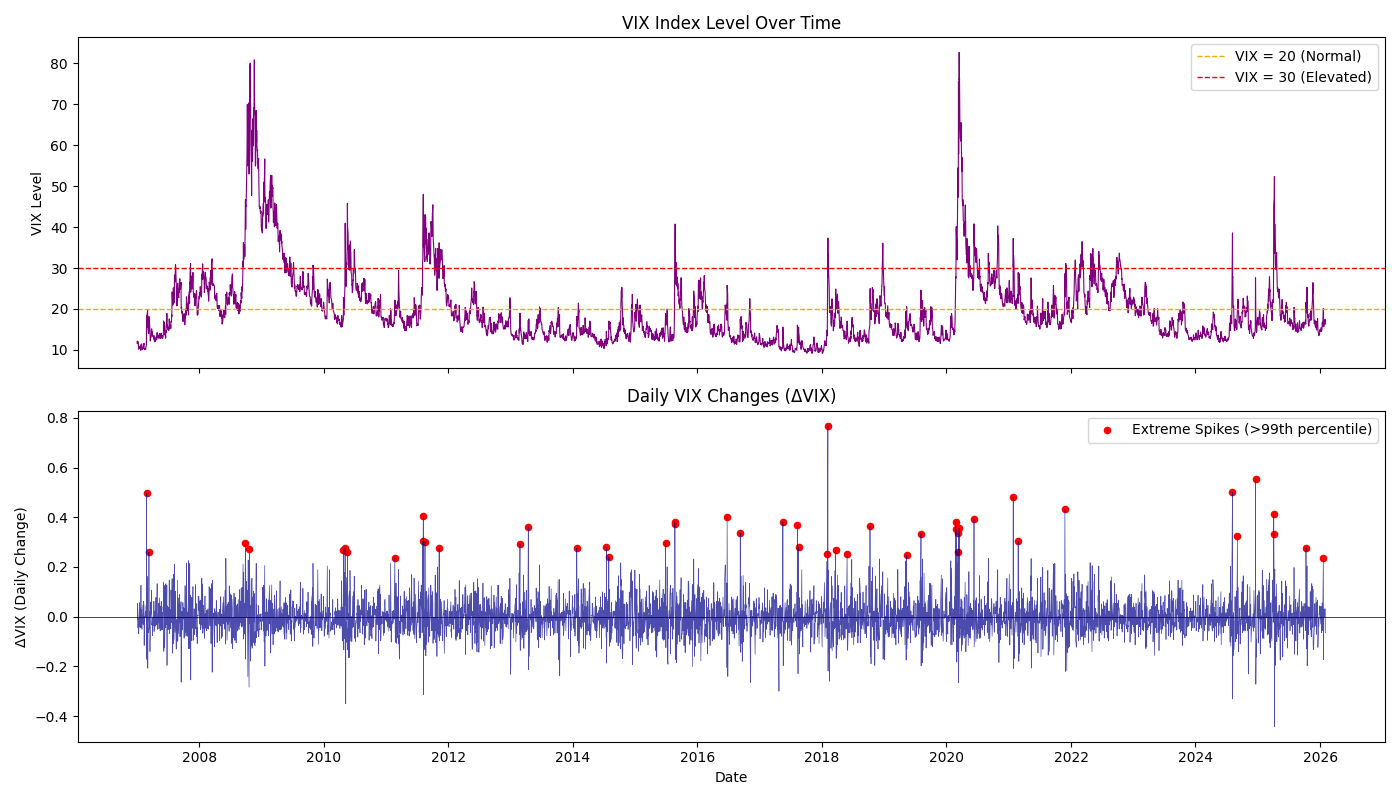

Figure 2: VIX level and daily changes showing volatility regime transitions.


In [108]:
# Figure 2: VIX Changes Over Time
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot VIX level
axes[0].plot(VIX["Close"], color='purple', linewidth=0.8)
axes[0].set_ylabel('VIX Level')
axes[0].set_title('VIX Index Level Over Time')
axes[0].axhline(y=20, color='orange', linestyle='--', linewidth=1, label='VIX = 20 (Normal)')
axes[0].axhline(y=30, color='red', linestyle='--', linewidth=1, label='VIX = 30 (Elevated)')
axes[0].legend()

# Plot VIX change (ΔVIX)
axes[1].plot(VIX_log_returns.index, VIX_log_returns['Close'], color='darkblue', alpha=0.7, linewidth=0.5)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_ylabel('ΔVIX (Daily Change)')
axes[1].set_title('Daily VIX Changes (ΔVIX)')
axes[1].set_xlabel('Date')

# Highlight extreme VIX spikes
vix_spikes = VIX_log_returns['Close'] > VIX_log_returns['Close'].quantile(0.99)
axes[1].scatter(VIX_log_returns.index[vix_spikes], VIX_log_returns.loc[vix_spikes, 'Close'],
                color='red', s=20, label='Extreme Spikes (>99th percentile)')
axes[1].legend()

plt.tight_layout()
plt.savefig('vix_changes_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure 2: VIX level and daily changes showing volatility regime transitions.")

In [109]:
# Step 2: Modeling VIX Regimes

# Here we define the function of discretize vix changes 

# Discretize ΔVIX into states using quantiles
def discretize_vix_changes(vix_changes, n_states=3):
    """
    Discretize VIX changes into n_states using quantile-based thresholds.
    """
    if n_states == 2:
        threshold = vix_changes.quantile(0.5)
        states = pd.Series(np.where(vix_changes <= threshold, 0, 1), index=vix_changes.index)
        state_labels = {0: 'Low Vol', 1: 'High Vol'}
    elif n_states == 3:
        q33 = vix_changes.quantile(0.33)
        q67 = vix_changes.quantile(0.67)
        conditions = [
            vix_changes <= q33,
            (vix_changes > q33) & (vix_changes <= q67),
            vix_changes > q67
        ]
        states = pd.Series(np.select(conditions, [0, 1, 2]), index=vix_changes.index)
        state_labels = {0: 'Low Vol', 1: 'Medium Vol', 2: 'High Vol'}

    return states, state_labels

In [110]:
# Create 2-state and 3-state discretizations
states_2, labels_2 = discretize_vix_changes(VIX_log_returns['Close'], n_states=2)
states_3, labels_3 = discretize_vix_changes(VIX_log_returns['Close'], n_states=3)

print("=== Discretization Results ===")
print(f"\n2-State Distribution:\n{states_2.value_counts().sort_index()}")
print(f"\n3-State Distribution:\n{states_3.value_counts().sort_index()}")



=== Discretization Results ===

2-State Distribution:
0    2400
1    2400
Name: count, dtype: int64

3-State Distribution:
0    1584
1    1632
2    1584
Name: count, dtype: int64


In [111]:
# Estimate Transition Matrix
def estimate_transition_matrix(states, n_states):
    """
    Estimate transition matrix from state sequence.
    """
    transition_counts = np.zeros((n_states, n_states))

    for i in range(len(states) - 1):
        current_state = int(states.iloc[i])
        next_state = int(states.iloc[i + 1])
        transition_counts[current_state, next_state] += 1

    # Normalize to get probabilities
    row_sums = transition_counts.sum(axis=1, keepdims=True)
    transition_matrix = transition_counts / row_sums

    return transition_matrix, transition_counts

In [112]:
# 2-State Markov Chain
trans_matrix_2, counts_2 = estimate_transition_matrix(states_2, 2)
print("\n=== 2-State Transition Matrix ===")
trans_df_2 = pd.DataFrame(trans_matrix_2,
                          index=['From Low Vol', 'From High Vol'],
                          columns=['To Low Vol', 'To High Vol'])
print(trans_df_2.round(4))

# 3-State Markov Chain
trans_matrix_3, counts_3 = estimate_transition_matrix(states_3, 3)
print("\n=== 3-State Transition Matrix ===")
trans_df_3 = pd.DataFrame(trans_matrix_3,
                          index=['From Low', 'From Medium', 'From High'],
                          columns=['To Low', 'To Medium', 'To High'])
print(trans_df_3.round(4))


=== 2-State Transition Matrix ===
               To Low Vol  To High Vol
From Low Vol       0.4756       0.5244
From High Vol      0.5242       0.4758

=== 3-State Transition Matrix ===
             To Low  To Medium  To High
From Low     0.3241     0.3392   0.3367
From Medium  0.2721     0.3799   0.3480
From High    0.3952     0.2999   0.3049


In [113]:
# Compute Stationary Distribution
def compute_stationary_distribution(trans_matrix):
    """
    Compute stationary distribution of Markov chain.
    """
    eigenvalues, eigenvectors = np.linalg.eig(trans_matrix.T)

    # Find eigenvector corresponding to eigenvalue 1
    idx = np.argmin(np.abs(eigenvalues - 1))
    stationary = np.real(eigenvectors[:, idx])
    stationary = stationary / stationary.sum()

    return stationary

stat_dist_2 = compute_stationary_distribution(trans_matrix_2)
stat_dist_3 = compute_stationary_distribution(trans_matrix_3)

print("\n=== Stationary Distributions ===")
print(f"2-State: Low Vol = {stat_dist_2[0]:.4f}, High Vol = {stat_dist_2[1]:.4f}")
print(f"3-State: Low = {stat_dist_3[0]:.4f}, Medium = {stat_dist_3[1]:.4f}, High = {stat_dist_3[2]:.4f}")


=== Stationary Distributions ===
2-State: Low Vol = 0.4999, High Vol = 0.5001
3-State: Low = 0.3299, Medium = 0.3401, High = 0.3301


In [114]:
VIX_log_returns.dropna()

,Close
Date,
2007-01-04 00:00:00-05:00,-0.045018
2007-01-05 00:00:00-05:00,0.053290
2007-01-08 00:00:00-05:00,-0.011599
2007-01-09 00:00:00-05:00,-0.007528
2007-01-10 00:00:00-05:00,-0.037643
...,...
2026-01-27 00:00:00-05:00,0.012308
2026-01-28 00:00:00-05:00,0.000000
2026-01-29 00:00:00-05:00,0.031902


In [115]:
# Prepare data for HMM
VIX_log_returns['Close'].dropna()
vix_data = VIX_log_returns['Close'].values.reshape(-1, 1)


# Fit 2-State Gaussian HMM
np.random.seed(42)
hmm_2 = hmm.GaussianHMM(n_components=2, covariance_type='full', n_iter=1000, random_state=42)
hmm_2.fit(vix_data)

# Extract parameters
print("\n=== 2-State HMM Parameters ===")
print(f"Means: {hmm_2.means_.flatten()}")
print(f"Variances: {hmm_2.covars_.flatten()}")
print(f"Transition Matrix:\n{hmm_2.transmat_}")
print(f"Initial State Probabilities: {hmm_2.startprob_}")
print(f"Log-Likelihood: {hmm_2.score(vix_data):.2f}")

# Get most likely state sequence (Viterbi)
hidden_states_2 = hmm_2.predict(vix_data)

# Get smoothed probabilities
state_probs_2 = hmm_2.predict_proba(vix_data)

# Fit 3-State Gaussian HMM
np.random.seed(42)
hmm_3 = hmm.GaussianHMM(n_components=3, covariance_type='full', n_iter=1000, random_state=42)
hmm_3.fit(vix_data)

print("\n=== 3-State HMM Parameters ===")
print(f"Means: {hmm_3.means_.flatten()}")
print(f"Transition Matrix:\n{hmm_3.transmat_}")
print(f"Log-Likelihood: {hmm_3.score(vix_data):.2f}")

# Get most likely state sequence
hidden_states_3 = hmm_3.predict(vix_data)
state_probs_3 = hmm_3.predict_proba(vix_data)



=== 2-State HMM Parameters ===
Means: [-0.00551397  0.01852905]
Variances: [0.00256266 0.01688783]
Transition Matrix:
[[0.95058197 0.04941803]
 [0.16352067 0.83647933]]
Initial State Probabilities: [1.00000000e+00 2.17230149e-22]
Log-Likelihood: 6031.22

=== 3-State HMM Parameters ===
Means: [-0.06000373  0.05930807 -0.00362789]
Transition Matrix:
[[2.24973439e-01 4.64901170e-01 3.10125390e-01]
 [5.58274516e-01 4.41634044e-01 9.14398020e-05]
 [1.55809100e-08 5.16587105e-02 9.48341274e-01]]
Log-Likelihood: 6095.53


In [116]:
# Sort states by mean (for consistent interpretation)
def sort_hmm_states(hmm_model, states, state_probs):
    """
    Reorder HMM states so that state 0 has lowest mean, etc.
    """
    means = hmm_model.means_.flatten()
    order = np.argsort(means)

    # Create mapping
    new_states = np.zeros_like(states)
    new_probs = np.zeros_like(state_probs)

    for new_idx, old_idx in enumerate(order):
        new_states[states == old_idx] = new_idx
        new_probs[:, new_idx] = state_probs[:, old_idx]

    return new_states, new_probs, order

hidden_states_2_sorted, state_probs_2_sorted, order_2 = sort_hmm_states(hmm_2, hidden_states_2, state_probs_2)
hidden_states_3_sorted, state_probs_3_sorted, order_3 = sort_hmm_states(hmm_3, hidden_states_3, state_probs_3)

In [117]:
# Add to dataframe
VIX_log_returns['MC_State_2'] = states_2.values
VIX_log_returns['MC_State_3'] = states_3.values
VIX_log_returns['HMM_State_2'] = hidden_states_2_sorted
VIX_log_returns['HMM_State_3'] = hidden_states_3_sorted

print("\nState sequences added to log_returns DataFrame")
print(f"Columns: {VIX_log_returns.columns.tolist()}")




State sequences added to log_returns DataFrame
Columns: ['Close', 'MC_State_2', 'MC_State_3', 'HMM_State_2', 'HMM_State_3']


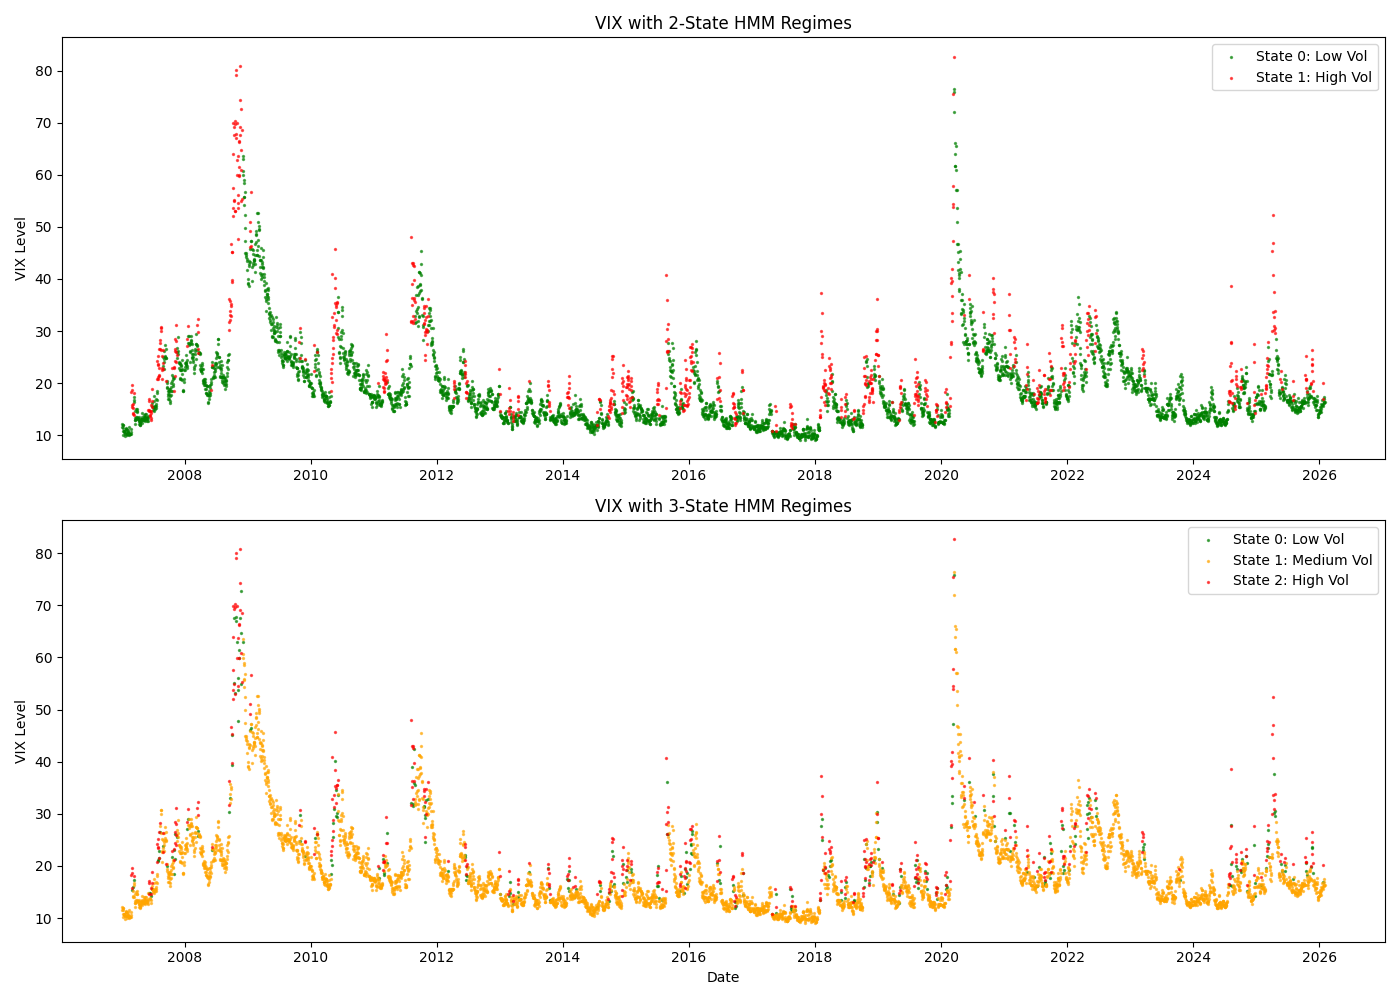

In [118]:
# Plot VIX with color-coded HMM states
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 2-State HMM
colors_2 = {0: 'green', 1: 'red'}
state_names_2 = {0: 'Low Vol', 1: 'High Vol'}

for state in [0, 1]:
    mask = VIX_log_returns['HMM_State_2'] == state
    axes[0].scatter(VIX_log_returns.index[mask], VIX_historical.loc[VIX_log_returns.index[mask], 'Close'],
                   c=colors_2[state], s=2, alpha=0.6,
                   label=f'State {state}: {state_names_2[state]}')

axes[0].set_ylabel('VIX Level')
axes[0].set_title('VIX with 2-State HMM Regimes')
axes[0].legend()

# 3-State HMM
colors_3 = {0: 'green', 1: 'orange', 2: 'red'}
state_names_3 = {0: 'Low Vol', 1: 'Medium Vol', 2: 'High Vol'}

for state in [0, 1, 2]:
    mask = VIX_log_returns['HMM_State_3'] == state
    axes[1].scatter(VIX_log_returns.index[mask], VIX_historical.loc[VIX_log_returns.index[mask], 'Close'],
                   c=colors_3[state], s=2, alpha=0.6,
                   label=f'State {state}: {state_names_3[state]}')

axes[1].set_ylabel('VIX Level')
axes[1].set_xlabel('Date')
axes[1].set_title('VIX with 3-State HMM Regimes')
axes[1].legend()

plt.tight_layout()
plt.show()


In [22]:
VIX_historical

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-06-02 00:00:00-04:00,21.320000,21.680000,21.299999,21.480000,0,0.0,0.0
2000-06-05 00:00:00-04:00,23.059999,23.290001,22.590000,22.709999,0,0.0,0.0
2000-06-06 00:00:00-04:00,23.200001,23.240000,22.719999,23.049999,0,0.0,0.0
2000-06-07 00:00:00-04:00,23.170000,23.400000,22.340000,22.480000,0,0.0,0.0
2000-06-08 00:00:00-04:00,23.360001,23.530001,22.770000,22.770000,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-27 00:00:00-05:00,16.020000,16.370001,15.740000,16.350000,0,0.0,0.0
2026-01-28 00:00:00-05:00,16.090000,17.180000,16.049999,16.350000,0,0.0,0.0
2026-01-29 00:00:00-05:00,16.040001,19.740000,16.020000,16.879999,0,0.0,0.0


# Vix futures strategy: 

In [120]:
pip install TA-lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 11.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [TA-lib]

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [121]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import talib as tb
import seaborn as sns
from datetime import date, timedelta, datetime
from dateutil import parser
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import export_text
from sklearn import tree, datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score, confusion_matrix
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (24, 12)
plt.style.use('fivethirtyeight')

To calculate the current level of contango we use the following formula: 

\begin{equation}
\mathrm{Ct}_{\mathrm{M}_{\mathrm{i}}, \mathrm{M}_{\mathrm{i}+1}}=\frac{\left(\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}+1}}-\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}}}\right) \cdot 100}{\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}}}}
\end{equation}

Where:

- $\mathrm{Ct}_{\mathrm{M}_{\mathrm{j}}, \mathrm{M}_{\mathrm{i}+1}}$ is % Contango between month $\mathrm{M}_{\mathrm{i}+1}$ and month $\mathrm{M}_{\mathrm{i}}$ VIX Futures.
- $\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}+1}}$ and FVIX $\mathrm{M}_{\mathrm{i}}$ are VIX future values at month $\mathrm{M}_{\mathrm{i}+1}$ and $\mathrm{M}_{\mathrm{i}}$ respectively.



In [124]:
VVIX

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-01-03 00:00:00-05:00,87.629997,87.629997,87.629997,87.629997,0.0,0.0,0.0
2007-01-04 00:00:00-05:00,88.190002,88.190002,88.190002,88.190002,0.0,0.0,0.0
2007-01-05 00:00:00-05:00,90.169998,90.169998,90.169998,90.169998,0.0,0.0,0.0
2007-01-08 00:00:00-05:00,92.040001,92.040001,92.040001,92.040001,0.0,0.0,0.0
2007-01-09 00:00:00-05:00,92.760002,92.760002,92.760002,92.760002,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-27 00:00:00-05:00,99.910004,101.260002,97.980003,101.260002,0.0,0.0,0.0
2026-01-28 00:00:00-05:00,101.489998,107.839996,99.000000,100.459999,0.0,0.0,0.0
2026-01-29 00:00:00-05:00,102.919998,111.919998,101.680000,101.760002,0.0,0.0,0.0
